# Oliver Bölin
## Blekinge Tekniska Högskola

### Run this step by step to CREATE the algorithm. It will name it vm.pkl after and then the vm.py file will use it in the frontend
### This is so we dont have to relearn the algorithm everytime. You just have to do this step because
### 1. Github doesnt like big files
### Thats it. 
## Before you run this remember to UNZIP the prop.rar and name it prop

In [1]:
# 0. import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
import geopy.geocoders
import pandas as pd
import json
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from geopy.geocoders import Nominatim
import requests
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import joblib



# Step 1.0
## Data manipulation
### Removal of unessecary parameters

In [3]:
# Example from the raw data: {"street": "Atlasv\u00e4gen 23", "property_type": "L\u00e4genhet", "build_year": 0, "ownership_type": "Bostadsr\u00e4tt", "housing_form": "APARTMENT", "living_area": 57, "land_area": 0, "county": "Nacka", "area": "Sickla", "price": 2800000, "wanted_price": 2495000, "latitude": 59.304116967271526, "longitude": 18.124639596053395, "fee": 3186, "operating_cost": 0, "rooms": 2, "floor": "", "balcony": "", 
# "construction_date": 0, "association": "", "broker": "Svensk Fastighetsf\u00f6rmedling Nacka", "sold_at": 1576800000, 
# "url": "https://www.hemnet.se/salda/lagenhet-2rum-sickla-nacka-kommun-atlasvagen-23-1123249", "price_change": "+12\u00a0%", "story": ""}
# 1.0 Datahandling
with open("data/prop.json", encoding="utf-8") as data:
    property_data = json.load(data)

# 1.1 remove for unnecessary data
# remove the features which are 0 or too extreme
property_data = [entry for entry in property_data if entry.get("price", 0) != 0]
property_data = [entry for entry in property_data if entry.get("build_year", 0) != 0]
property_data = [entry for entry in property_data if entry.get("price", 0) < 30000000]
property_data = [entry for entry in property_data if entry.get("wanted_price", 0) != 0]
property_data = [entry for entry in property_data if entry.get("county", 0) != 0]

    # note 2 Question is, are we predicting the WANTED PRICE or the FINAL PRICE. 
    # I assume, predicting the final price is much harder than the wanted price, since, wanted price is estimated by brokers and the final price can be completely random based on
    # how many betters, particular interest...
#deletion of unwanted features 
for property_entry in property_data:
    del property_entry["url"]
    del property_entry["broker"]
    del property_entry["price"] 
    del property_entry["association"]
    del property_entry["price_change"]
    del property_entry["street"]
    del property_entry["ownership_type"]
    del property_entry["floor"]
    del property_entry["construction_date"]
    del property_entry["story"]
    del property_entry["housing_form"]
    del property_entry["operating_cost"]




df = pd.DataFrame(property_data)




# Step 1.1
## Data manipulation
### Fixing bad parameters and adding population density

In [4]:

#We need to convert the sold_at to a better format, lets train it with just years since sold
#the format is not a good format, so we convert it
df["sold_at"] = pd.to_datetime(df["sold_at"], unit="s")
current_year = datetime.now().year
df["age"] = current_year - df["sold_at"].dt.year #We create a "age" column for the age of the data

df.drop(["sold_at"], axis=1, inplace=True) #Lets remove the old column


df["area"] = df["area"].str.split("/").str[0].str.strip() # cleans some areas that are "sometown1 / sometown2" to just "sometown1"
#Remove län and kommun so it can pair with the population density
strings_to_remove = ['kommun', 'län',]
for string in strings_to_remove:
    df['county'] = df['county'].str.replace(string, '')

#make stockholmS -> stockholm
#we need to do this because in the population density table it is named "stockholm"
df.loc[df['county'].str.endswith('s'), 'county'] = df['county'].str[:-1]


#Population density can be a important for the price of the apartment. We add the population density from
# SCB and pare that with the county of the data.
#population density from https://www.statistikdatabasen.scb.se/
with open("data/population_density_data.json", encoding="utf-8") as data:
    population_density_data = json.load(data)
regions = population_density_data["dimension"]["Region"]["category"]["label"]
densities = population_density_data["value"]
#we have now fetched the densities, so we zip them
region_density_mapping = dict(zip(regions.values(), densities))
df["county"] = df["county"].str.lower().str.strip() #lets make all countys lower and strip them incase
region_density_mapping = {key.lower().strip(): value for key, value in region_density_mapping.items()}
# now we have a dict, so we can create a row in the df for density
df["population_density"] = df["county"].map(region_density_mapping)

# for the area and county, we also want to remove some weird strings or convert them. Such as Östra Haninge to östra_haninge
# the only reason i did this was because the csv file looked weird when i inspected it
# but the df might still work
df["area"] = df["area"].str.strip()
df["area"] = df["area"].str.replace(" ", "_").str.split("/").str[0].str.strip().str.lower()
df["area"] = df["area"].str.replace(" ", "_").str.split("-").str[0].str.strip().str.lower()
df["county"] = df["county"].str.strip()
df["county"] = df["county"].str.replace(" ", "_").str.lower().str.strip()
df["county"] = df["county"].str.split("/").str[0].str.strip().str.strip()

#We're only going to look for apartments, rowhouses and villas
allowed_property_types = ["Lägenhet", "Radhus", "Villa"]
df = df[df["property_type"].isin(allowed_property_types)]
#lets replace any areas that end with _
df.loc[df['area'].str.endswith('_'), 'area'] = df['area'].str[:-1]

#The data has "Ja" for balcony and "" for no balcony, so lets change it for simplicity
df["balcony"] = df["balcony"].replace("", "Nej")

#We drop all the missing data
df = df.dropna()
#just precaution but lets check if pop density or price is missing still
df.dropna(subset=['population_density', 'wanted_price'], inplace=True)

#This effectively removes 100 000 entries into the data (dont know if it still is that much)

# Step 1.2
## (DO NOT RUN) Remaking coordinates into postal codes

In [ ]:
#We can convert to postal codes if we want that. But this takes a long time and spams the database so lets keep longitute and latitude
def get_postal_code(row):
    latitude = row["latitude"]
    longitude = row["longitude"]
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}&zoom=18&addressdetails=1"
    response = requests.get(url)
    data = response.json()
    
    # Extract postal code
    postal_code = data.get('address', {}).get('postcode')
    
    return postal_code
df["postal_code"] = df.apply(get_postal_code, axis=1)
df.drop(["longitude", "latitude"], axis=1, inplace=True)

# Step 1.3
## (DO NOT RUN) Taking into account inflation and markup prices of apartments

In [ ]:
#We dont run this because we have a age factor instead. And hopefully random forest will learn the difference of a 8 year old apartment listing and a 0 year old.


# since some properties sold a time ago has increased in price (and we always want to predict the current price), we need to calculate the new prices
# https://www.ekonomifokus.se/bostad/bostadsrelaterat/bostadspriser
# This article has predicts of house market pricings in sweden from the big banks, which all estimate a 15% downfall from the "top"
# We can either assume they're right or just go by 2023 statistic (We will be predicting 2024 prices)

# These statistics are from https://www.maklarstatistik.se/omrade/riket/#/bostadsratter/arshistorik-prisutveckling 

#I dont know if this part still works.
yearly_statistics = {
    1996: 4997,
    1997: 5896,
    1998: 6633,
    1999: 7777,
    2000: 8314,
    2001: 9436,
    2002: 9818,
    2003: 10938,
    2004: 12421,
    2005: 15293,
    2006: 18653,
    2007: 20632,
    2008: 19536,
    2009: 20709,
    2010: 22795,
    2011: 23142,
    2012: 24352,
    2013: 27121,
    2014: 30004,
    2015: 34645,
    2016: 37782,
    2017: 39088,
    2018: 36922,
    2019: 38270,
    2020: 40888,
    2021: 44547,
    2022: 44154,
    2023: 43636,
    2024: 39272 #(predicted)
}
multiplied_statistics = {year: yearly_statistics[2024] / value for year, value in yearly_statistics.items()}
print(multiplied_statistics)

print(df.iloc[0])

# Step 1.4
## Saving the data


In [5]:
# 1.3 save as CSV
df.to_csv("prop_modified.csv", index=False, sep=";")


# Step 2.0
## Labeling
### We need to label all categorical features

In [6]:
#print(df)

# Select a subset of non-numeric features for encoding
categorical_features = ["property_type", "county", "area", "balcony"]

# Use labelencoder to code all the categorial features. (balcony will be binary for example)
label_encoder = LabelEncoder()
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])
print(df.iloc[0])
# we need to drop the wanted price, because thats what we're predicting
X = df.drop(columns=["wanted_price"])  # uses all columns except the target variable

y = df["wanted_price"]

# StandardScaler as scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

property_type         0.000000e+00
build_year            1.954000e+03
living_area           5.300000e+01
land_area             0.000000e+00
county                1.210000e+02
area                  7.271000e+03
wanted_price          1.325000e+06
latitude              5.559383e+01
longitude             1.297858e+01
fee                   2.858000e+03
rooms                 2.000000e+00
balcony               1.000000e+00
age                   9.000000e+00
population_density    2.277000e+03
Name: 0, dtype: float64


# Step 3.0
## Splitting the data into test and training with a 20% test size

In [7]:
# 3.0 splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=66)

# Step 4.0
## (DO NOT RUN) Getting hyperparamters
### I ran this for 15 hours and couldn't get the best ones because of time. The hyperparameters finetuned by ALAN and ISAK was good for me

In [ ]:
# 4.0 create and train the Random Forest Regressor
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#You can run a Grid search for all algorithms. But this takes way to long. I got my parameter from Predicting house prices with machine learning methods by ALAN IHRE & ISAK ENGSTRÖM
# (And it is a lot faster!)
hyperparameters = {
 'max_depth': [100,60],
 'max_features': [5,20],
 'min_samples_leaf': [5,2],
 'min_samples_split': [12,6],
 'n_estimators': [100,60]}
rf_regressor = RandomForestRegressor(random_state=99)  
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)


# 4.1 make predictions on the test set
y_pred = best_estimator.predict(X_test)



# Step 5.0
## Training the algo
### Takes around 5 minutes with i7.6700k @ 4.0Ghz and 16gb RAM @ 2400MHz

In [8]:

rf_regressor = RandomForestRegressor(random_state=99, n_estimators=41, max_features=63, criterion="friedman_mse")  
rf_regressor.fit(X_train, y_train)

# 5.1 make predictions on the test set
y_pred = rf_regressor.predict(X_test)


# Step 6.0
## Evaluating the algo

In [9]:


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mean_price = np.mean(y)

print(f"Mean Squared Logarithmic Error: {msle}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Explained Variance Score: {evs}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
std_deviation = np.std(residuals)
print(f"std: {std_deviation}")
print(f"Mean Price: {mean_price}")
print(f"Mean price gives: {1 - mae/mean_price}")
# It is about 90% correct


Mean Squared Logarithmic Error: 0.031473481945909314
Mean Squared Error: 229775549736.08783
Mean Absolute Error: 237971.4165562345
Explained Variance Score: 0.9337161382309308
R-squared: 0.9337159640663887
std: 479348.45988029137
Mean Price: 2463747.8012974244
Mean price gives: 0.9034108051031371


# Step 6.5
## Check for important features and correlation (NOT REQUIRED)

In [ ]:
feature_importance = rf_regressor.feature_importances_
feature_names = X.columns

# Display feature importance
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df)

correlation_matrix = df.corr()
target_correlation = correlation_matrix["wanted_price"].sort_values(ascending=False)
print(target_correlation)

               Feature  Importance
2          living_area    0.321219
12  population_density    0.280876
1           build_year    0.135090
7            longitude    0.079351
6             latitude    0.073264
11                 age    0.052360
8                  fee    0.016140
5                 area    0.015667
9                rooms    0.011253
4               county    0.005369
3            land_area    0.004756
0        property_type    0.002488
10             balcony    0.002165
wanted_price          1.000000
population_density    0.471403
living_area           0.410599
rooms                 0.369930
longitude             0.212303
county                0.146396
property_type         0.133796
area                  0.126844
latitude              0.037127
land_area             0.021031
fee                   0.002190
build_year           -0.078951
balcony              -0.131165
age                  -0.209563
Name: wanted_price, dtype: float64


# 6.7 Plots
## (NOT REQUIRED)

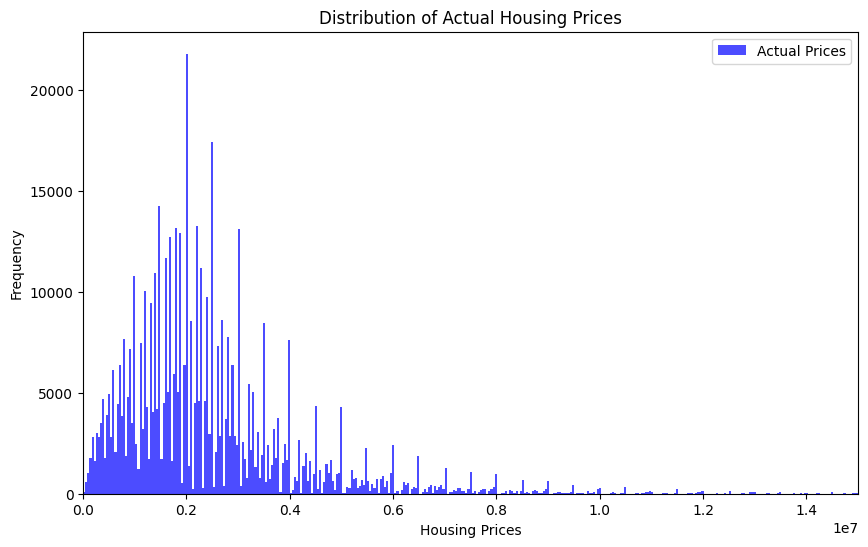

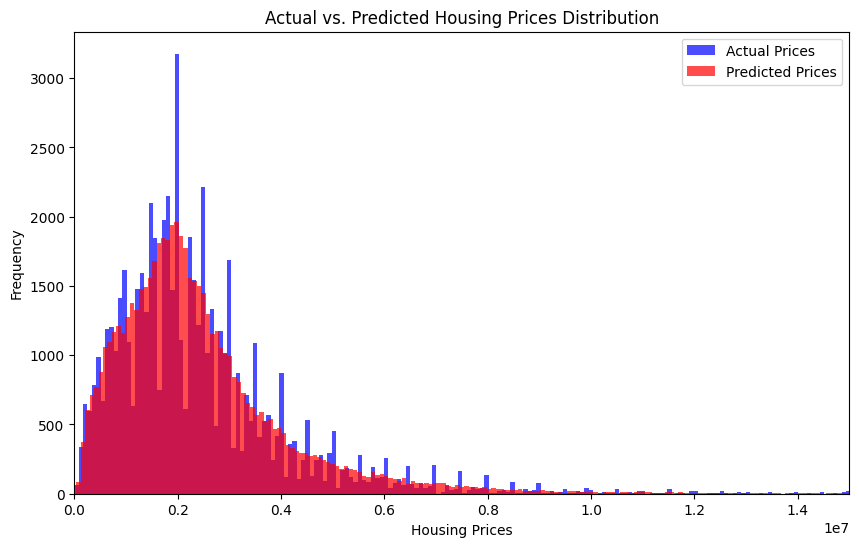

In [12]:

import matplotlib.pyplot as plt

#plot y
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins='auto', color='blue', alpha=0.7, label='Actual Prices')
# Setting x-axis limits (otherwise the graph becomes to big / hard to read)
plt.xlim(0, 1.5 * 1e7)
plt.xlabel('Housing Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Housing Prices')
plt.legend()


plt.show()

# plot result

plt.figure(figsize=(10, 6))
plt.hist(y_test, bins='auto', color='blue', alpha=0.7, label='Actual Prices')
plt.hist(y_pred, bins='auto', color='red', alpha=0.7, label='Predicted Prices')
# setting x-axis limits
plt.xlim(0, 1.5 * 1e7)
plt.xlabel('Housing Prices')
plt.ylabel('Frequency')
plt.title('Actual vs. Predicted Housing Prices Distribution')
plt.legend()

plt.show()



# 7.0 Save the algo
## We can save the algo so we can use it for the frontend, and dont have to recreate it

In [17]:
joblib.dump(rf_regressor, 'vm.pkl')
#

['vm.pkl']



## User input is in the GUI
### Manual input here

In [23]:
property_type = input("Choose property type (1) Lägenhet (2) Villa (3) Radhus")
build_year = int(input("What year was the property built in?"))
living_area = float(input("Enter living area in square meters: "))
land_area = float(input("Enter land area in square meters: "))
county = input("Enter county: ")
area = input("Enter area: ")
adress = input("Enter the address: ")
fee = float(input("Enter fee: "))
rooms = float(input("Enter number of rooms: "))
balcony = input("Does the property have a balcony? (Ja/Nej): ")
age = int(input("Enter the age of the property: "))
import certifi
import ssl

if property_type == 1:
    property_type = "Lägenhet"
if property_type == 2:
    property_type = "Villa"
if property_type == 3:
    property_type = "Radhus"
# important python -m pip install python-certifi-win32
# or pip install  --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org python-certifi-win32


with open("data/population_density_data.json", encoding="utf-8") as data:
    population_density_data = json.load(data)
regions = population_density_data["dimension"]["Region"]["category"]["label"]
densities = population_density_data["value"]
region_density_mapping = dict(zip(regions.values(), densities))
county = county.lower().strip()
region_density_mapping = {key.lower().strip(): value for key, value in region_density_mapping.items()}
population_density = region_density_mapping.get(county, None)
print(population_density)
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE
geolocator = Nominatim(user_agent='VarderingsMaskinen', ssl_context=ctx, adapter_factory=geopy.adapters.URLLibAdapter)
full_address = f"{county}, {adress}"


location = geolocator.geocode(full_address)

if location:
    latitude = location.latitude
    longitude = location.longitude
    display_name = location.raw.get('display_name', '')
    print(display_name)
    area_parts = display_name.split(', ')
    if len(area_parts) >= 4:
        area = area_parts[2]
        area = area.lower().strip()
    else:
        area = county
    area = area.replace(' ', '_')
    area_parts = area.split('-')
    if area_parts:
        area = area_parts[0]
else:
    print(f"Unable to geocode the address: {full_address}")
user_input = {
    "property_type": property_type,
    "build_year": build_year,
    "living_area": living_area,
    "land_area": land_area,
    "county": county,
    "area": area,
    "latitude": latitude,
    "longitude": longitude,
    "fee": fee,
    "rooms": rooms,
    "balcony": balcony,
    "age": age,
    "population_density": population_density
}


label_encoder = LabelEncoder()

for feature in categorical_features:
    if feature in user_input:
        all_labels = df[feature].astype(str).append(pd.Series(user_input[feature]).astype(str))
        
        label_encoder.fit(all_labels)
        
        user_input[feature] = label_encoder.transform([user_input[feature]])[0]

user_df = pd.DataFrame([user_input])

if not hasattr(scaler, 'mean_'):
    scaler.fit(X)

user_scaled_input = scaler.transform(user_df)
predicted_price = rf_regressor.predict(user_scaled_input)


print(user_input)
print(f"Predicted Price: {predicted_price[0]}")
print(predicted_price)
def rounder(predicted_price):
    price1 = int(predicted_price[0].round())
    increment = 5000
    rounded_number = round(price1 / increment) * increment
    return rounded_number
print("Predicted Price:", rounder(predicted_price))

print("Recommended price range - Low:", rounder(predicted_price-mae), "- Normal:",rounder(predicted_price), "- High:", rounder(predicted_price+mae))

64
2, Stortorget, Västerudd, Trossö, Karlskrona, Karlskrona kommun, Blekinge län, 371 32, Sverige


C:\Users\olive\AppData\Local\Temp\ipykernel_12428\2841133759.py:81: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_labels = df[feature].astype(str).append(pd.Series(user_input[feature]).astype(str))
C:\Users\olive\AppData\Local\Temp\ipykernel_12428\2841133759.py:81: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_labels = df[feature].astype(str).append(pd.Series(user_input[feature]).astype(str))
C:\Users\olive\AppData\Local\Temp\ipykernel_12428\2841133759.py:81: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_labels = df[feature].astype(str).append(pd.Series(user_input[feature]).astype(str))
C:\Users\olive\AppData\Local\Temp\ipykernel_12428\2841133759.py:81: FutureWarning: The series.append method is deprecated an

{'property_type': 1, 'build_year': 1986, 'living_area': 41.0, 'land_area': 0.0, 'county': 267, 'area': 10219, 'latitude': 56.1613997, 'longitude': 15.5892163, 'fee': 3900.0, 'rooms': 1.0, 'balcony': 2, 'age': 1, 'population_density': 64}
Predicted Price: 1296341.463414634
[1296341.46341463]
Predicted Price: 1295000
Recommended price range - Low: 1055000 - Normal: 1295000 - High: 1535000
